In [175]:
import itertools
import requests
import pandas as pd
import numpy as np
from neo4j import GraphDatabase

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

In [2]:
API_TOKEN = 'gTROnCD7nMeifPU'
API_BASE_URL = ''

# 1. Build Graph

## 1.1. define specs

In [3]:
n_paper = 200

In [4]:
terms = [
    'Phenylketonuria',
    'Multiple Sclerosis',
    'Follicular lymphoma',
    'Hepatitis',
    'Epilepsy',
    'Hypothyroidism',
    'Hyperthyroidism'
]

In [5]:
pipe_cfg = {
    'pubmed': {
        'run': True
    },
    'ner': {
        'run': True,
        'entityLinks': True
    },
    'medGen': {
        'run': True,
        'Snomed': True,
        'clinicalFeatures': True
    },
    'uniProt': {'run': True}
}

## 1.2. prep request

In [6]:
def _get_request_json(serachterm, n_articles, pipe_cfg, delete_graph=False):
    return {
        'request_specs': {
            'disease': serachterm,
            'n_articles': n_articles,
            'delete_graph': delete_graph,
            'pipelines': pipe_cfg
        },
        'token': API_TOKEN
    }

In [7]:
_get_request_json(terms[0], n_paper, pipe_cfg, True)

{'request_specs': {'disease': 'Phenylketonuria',
  'n_articles': 200,
  'delete_graph': True,
  'pipelines': {'pubmed': {'run': True},
   'ner': {'run': True, 'entityLinks': True},
   'medGen': {'run': True, 'Snomed': True, 'clinicalFeatures': True},
   'uniProt': {'run': True}}},
 'token': 'gTROnCD7nMeifPU'}

## 1.3. make request to build KnowledgeGraph

In [8]:
def build_knowledge_graph(terms):
    for i, term in enumerate(terms):
        print(term)
        if i == 0:
            req_json = _get_request_json(term, n_paper, pipe_cfg, True)
        else:
            req_json = _get_request_json(term, n_paper, pipe_cfg, False)
        # make request
        r = requests.post(API_BASE_URL + '/buildGraph', json=req_json)
        print(r.text)

In [12]:
build_knowledge_graph(terms)

Phenylketonuria
success
Multiple Sclerosis
success
Follicular lymphoma
success
Hepatitis
success
Epilepsy
success
Hypothyroidism
success
Hyperthyroidism
success


# 2. Analyse node intersection

## 2.1. define specs

In [13]:
kg_level = ['DISEASE', 'CHEMICAL', 'UMLS', 'Gene', 'Protein', 'SnomedConcept', 'ClinicalFeature', 'GO']
terms = [t.lower() for t in terms if t != 'hypothyroidism']

## 2.2. get interesections from neo4j via pymedgraph API

In [176]:
def get_intersections(terms: list, kg_lvl: list):
    dfs = list()
    for lvl in kg_lvl:
        response = requests.get(
            API_BASE_URL + '/intersection',
            params={'searchTerms': ','.join(terms), 'level': lvl, 'token': API_TOKEN}
        )
        if response.json()[0] == 'success':
            dfs.append(pd.read_json(response.json()[1]))
        else:
            print(f'FAIL for level {lvl} with message {response.text}')
    return dfs

In [182]:
response = requests.get(
            API_BASE_URL + '/intersection',
            params={'searchTerms': ','.join(terms[:-1]), 'level': 'DISEASE', 'token': API_TOKEN}
        )

In [26]:
%%time
# make api requests
dfs = get_intersections(terms, kg_level)

CPU times: user 428 ms, sys: 56.9 ms, total: 485 ms
Wall time: 1min 13s


## 2.3. calculate relative intersection

In [27]:
def calculate_relative_intersections(dfs: list) -> pd.DataFrame:
    # merge dfs
    df = dfs[0]
    for i in range(len(dfs)):
        if i!=0:
            df = pd.merge(df, dfs[i], left_on=['e1', 'e2'], right_on=['e1', 'e2'], how='outer')
    # set total val
    terms = list(df['e1'].unique())
    # set total column and calc relative val
    for col in [c for c in df.columns if c not in ['e1', 'e2']]:
        for t in terms:    
            term_val = df[(df['e1'] == t) & (df['e2'] == t)][col].values[0]
            df.loc[df['e1'] == t, col+'_total'] = term_val
            # calculuate relative intersection
        df[col+'_intersection'] = (df[col] / df[col+'_total']).replace(np.inf, 0)
    return df

In [71]:
def get_mean_of_intersections(df, terms):
    cols = [c for c in df.columns if 'intersection' in c]
    df['intersection_mean'] = df[['e1', 'e2']+cols].sum(numeric_only=True,axis=1) / len(cols)
    df = df[['e1', 'e2', 'intersection_mean']].copy()
    result_vals = list()
    for c in itertools.combinations(terms, 2):
        indx = df[df[['e1', 'e2']].isin(c)].dropna(subset=['e1', 'e2']).index
        df_tmp = df.iloc[indx]
        val = df_tmp[df_tmp['e1'] != df_tmp['e2']]['intersection_mean'].mean()
        result_vals.append([c[0], c[1], val])
    return result_vals

In [72]:
df = calculate_relative_intersections(dfs)

In [73]:
intersection_values = get_mean_of_intersections(df, terms)

### 2.3.1 sub graph sizes

In [163]:
df_size = df[df['e1'] == df['e2']][
    [c for c in df.columns if 'intersection' not in c and 'total' not in c]
].drop('e1', axis=1).rename(columns={'e2': 'subgraph'}).reset_index(drop=True)
df_size['sum'] = df_size.sum(numeric_only=True,axis=1)

In [164]:
df_size

,subgraph,DISEASE,CHEMICAL,UMLS,Gene,Protein,SnomedConcept,ClinicalFeature,GO,sum
0,phenylketonuria,356,231,1407,34,26,105,173,650,2982
1,multiple sclerosis,441,134,1256,75,38,96,187,1124,3351
2,follicular lymphoma,320,142,1108,44,25,109,75,843,2666
3,hepatitis,261,165,746,47,28,76,106,888,2317
4,epilepsy,438,103,1065,53,28,86,328,1020,3121
5,hypothyroidism,566,214,1907,132,61,206,270,1508,4864
6,hyperthyroidism,550,232,1960,116,56,106,220,1682,4922


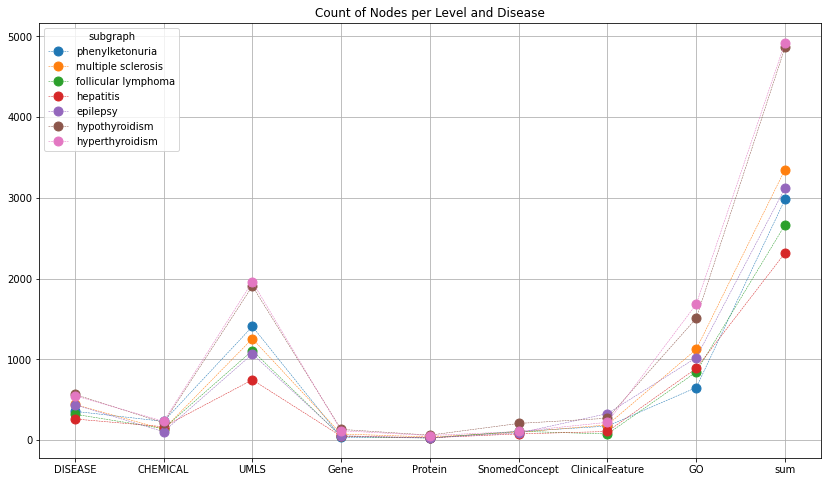

In [174]:
fig, ax = plt.subplots(figsize=(14,8))
df_size.set_index('subgraph').T.plot(ax=ax, marker='o', markersize=9, linestyle='--', linewidth=0.5)
plt.grid(True)
plt.title('Count of Nodes per Level and Disease')
plt.show()

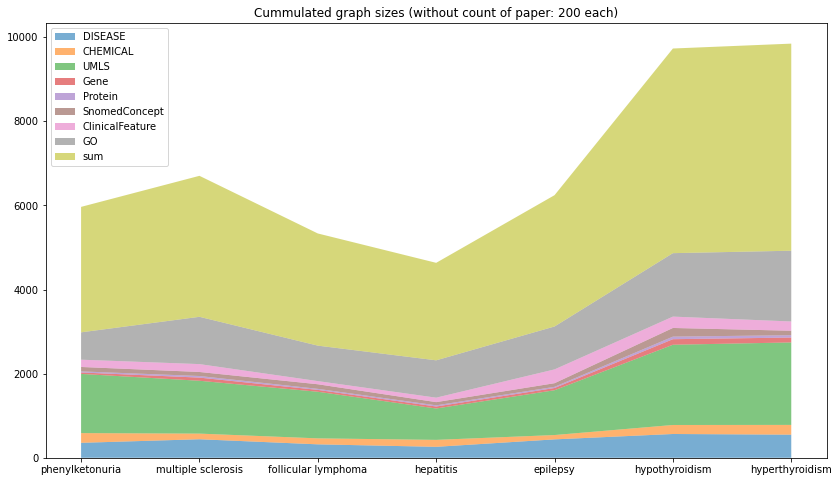

In [173]:
fig, ax = plt.subplots(figsize=(14,8))
# prep df
df_stack = df_size.reset_index(drop=True)
values = list()
val_cols = [c for c in df_stack.columns if c != 'subgraph']
for col in val_cols:
    values.append(df_stack[col].values)

# plot
plt.stackplot(
    df_stack.index,
    *values,
    alpha=0.6,
    labels=val_cols
)
ax.set_xticks(df_stack.index,labels=df_stack['subgraph'].values)
plt.legend(loc='upper left')
plt.title('Cummulated graph sizes (without count of paper: 200 each)')
plt.show()

### 2.3.2 result with calculated intersection 

In [74]:
dfr = pd.DataFrame(intersection_values, columns=['e1', 'e2', 'intersection'])

In [75]:
dfr[dfr['e1'] == 'phenylketonuria']

,e1,e2,intersection
0,phenylketonuria,multiple sclerosis,0.191109
1,phenylketonuria,follicular lymphoma,0.091069
2,phenylketonuria,hepatitis,0.230278
3,phenylketonuria,epilepsy,0.270232
4,phenylketonuria,hypothyroidism,0.368119
5,phenylketonuria,hyperthyroidism,0.299675


In [77]:
df_box = df[df['e1'] != df['e2']][[c for c in df.columns if 'intersection' in c]]

### 2.3.3 show distribution of intersaction values

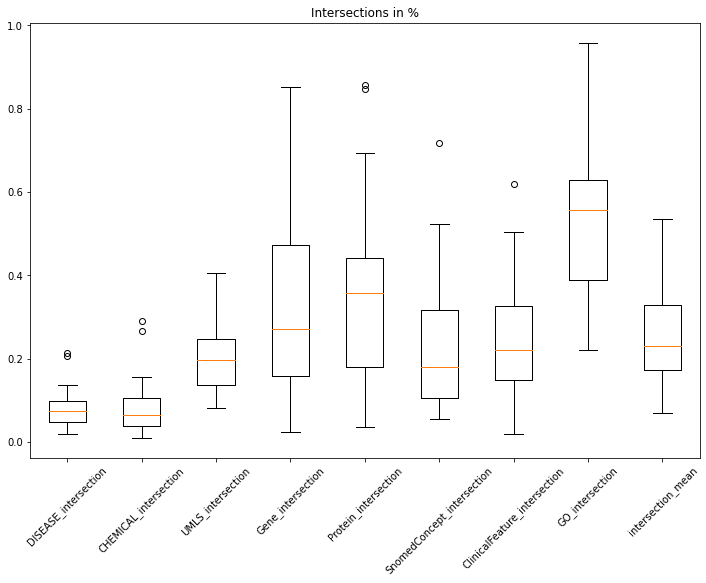

In [78]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Intersections in %')
ax.boxplot(df_box)
ax.set_xticklabels(df_box.columns, rotation=45)
plt.show()

### 2.3.4 result for each level

In [79]:
target_term = 'phenylketonuria'
df_lvl = df[(df['e1'] == target_term)&(df['e2'] != target_term)][
    ['e2']+[c for c in df.columns if 'intersection' in c]
].set_index('e2').copy()
df_lvl.columns = [c.replace('intersection', '').replace('_', '') for c in df_lvl.columns]

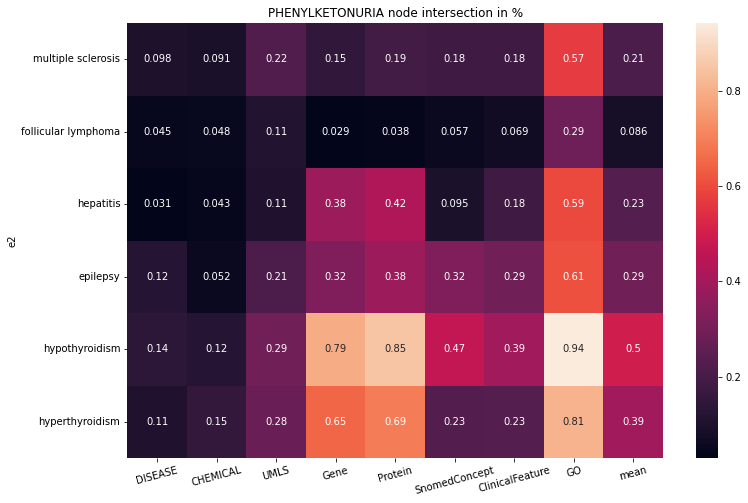

In [80]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_lvl, annot=True, ax=ax)
plt.xticks(rotation=15)
plt.title(f'{target_term.upper()} node intersection in %')
plt.show()